In [1]:
from fits_dataclass import Image, ImageSet, Transform
import matplotlib.pyplot as plt
import numpy as np
import astroscrappy
import glob
import copy

In [2]:
#Load a set of sample scam images from 2018 observations
base_path = '/Users/ryleighfitzpatrick/TitanMethane/sample_imgs/'

files = glob.glob(base_path+'jul*.fits')
scams = ImageSet([Image.load(file) for file in files])
bkg = Image.load(base_path+'bkg_2.fits')



In [3]:
#Cosmic Correct to make things easier
gain = 2.1
max_iter = 3
sig_clip = 5.0
sig_frac = 0.3
obj_lim = 5.0
readnoise=10.0

scams_cr = ImageSet([Image(_data=astroscrappy.detect_cosmics(s.data, pssl=0.0, gain=gain, 
                sigclip=sig_clip, sigfrac=sig_frac, objlim=obj_lim, 
                readnoise=readnoise, satlevel=np.inf, inmask=None,
                sepmed=False, cleantype='medmask', fsmode='median')[1],
            header = s.header) for s in scams])

bkg = astroscrappy.detect_cosmics(bkg.data, pssl=0.0, gain=gain, 
                sigclip=sig_clip, sigfrac=sig_frac, objlim=obj_lim, 
                readnoise=readnoise, satlevel=np.inf, inmask=None,
                sepmed=False, cleantype='medmask',fsmode='median')[1]

scams_bkg = [Image(_data=s.data-bkg, header=s.header) for s in scams_cr]

# Scale fainter half of detector

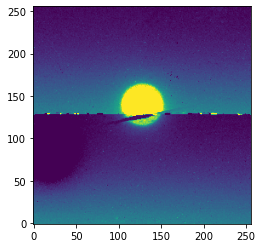

In [4]:
plt.imshow(scams_bkg[1].data, vmin=0, vmax=2000, origin='lower')

In [5]:
print(np.mean(scams_bkg[1].data[:128,:]))
print(np.mean(scams_bkg[1].data[129:,:]))

277.6677
457.9164


In [6]:
scale = np.round(np.mean(scams_bkg[1].data[129:,:])/np.mean(scams_bkg[1].data[:128,:]),2)

In [7]:
test = copy.copy(scams_bkg[1].data)

In [8]:
test[:128,:] = scams_bkg[1].data[:128,:]*scale

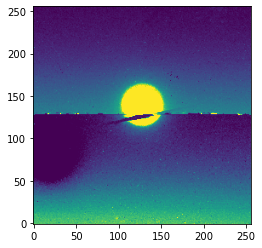

In [9]:
#Some thresholding to get rid of noise
test[test < 10] = 0
test[test > 3000] = 3000
plt.imshow(test, vmin=0, vmax = 2000, origin='lower')


# TO DO:
 - See what cause of scam detector brightness issue
 - See how other's have handled this!

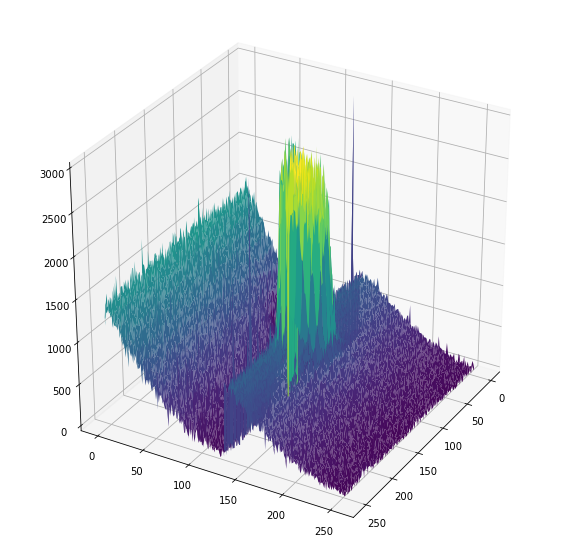

In [10]:
%matplotlib inline
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

x,y = np.meshgrid(range(256), range(256))

ax.plot_surface(x, y, test, cmap='viridis', edgecolor='none')
ax.view_init(elev=30, azim=30)


In [11]:
from cwt_2d import cwt_2d, _create_frequency_plane, _get_wavelet_mask

In [12]:
cwt = cwt_2d(test, [10], 'ft_mexh')

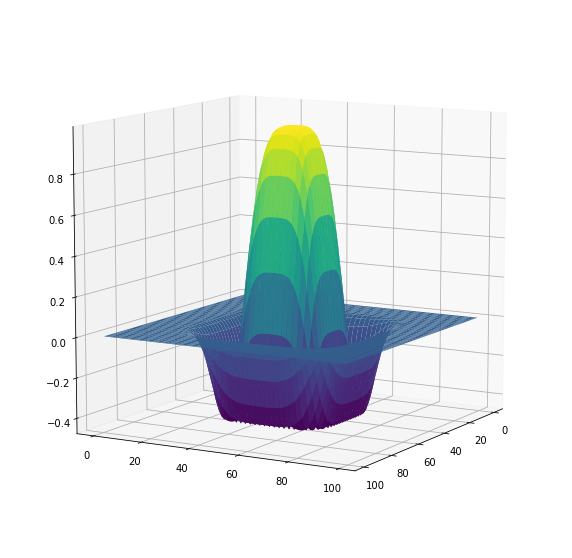

In [13]:
def ft_mexh(x, y):
    return (1. - (x**4. + y**4.))*np.exp(-0.5 * (x**4. + y**4.))

xx, yy = np.meshgrid(range(100), range(100))

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

a = np.zeros(shape=(100,100))

for x, i in zip(np.linspace(-3,3, num=100), range(100)):
    for y, j in zip(np.linspace(-3,3, num=100), range(100)):
        a[i,j] = ft_mexh(x,y)

ax.plot_surface(xx, yy, a, cmap='viridis', edgecolor='none')
ax.view_init(elev=10, azim=30)




In [16]:
peak, peak_x, peak_y = peak2d(np.real(cwt[0])[:,:,0])

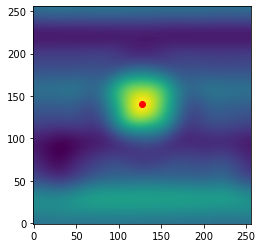

In [17]:
plt.imshow(np.real(cwt[0])[:,:,0], origin='lower')
plt.plot(peak_y, peak_x, 'o', color='r')

(100.0, 180.0)

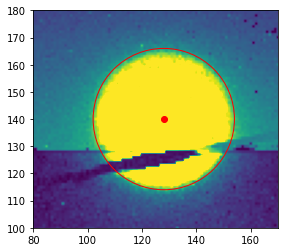

In [18]:
#Some thresholding to get rid of noise

fig, ax = plt.subplots()

test[test < 10] = 0
test[test > 3000] = 3000
plt.imshow(test, vmin=0, vmax = 2000, origin='lower')

plt.plot(peak_y, peak_x, 'o', color='r')

draw_circle = plt.Circle((peak_y, peak_x), 26, fill=None, color='r')
ax.add_artist(draw_circle)

ax.set_xlim(80,170)
ax.set_ylim(100,180)



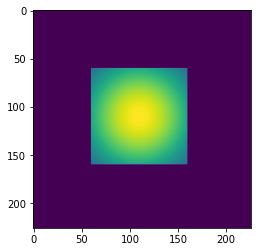

In [19]:
#Fake Data
x, y = np.meshgrid(np.linspace(-1,1,100), np.linspace(-1,1,100))
d = np.sqrt(x*x+y*y)
sigma, mu = 1.0, 0.0
g = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )

fake_img = np.zeros((226,226))
fake_img[60:160, 60:160] = g

plt.imshow(fake_img)

In [20]:
fake_cwt = cwt_2d(fake_img, [10], 'ft_mexh')

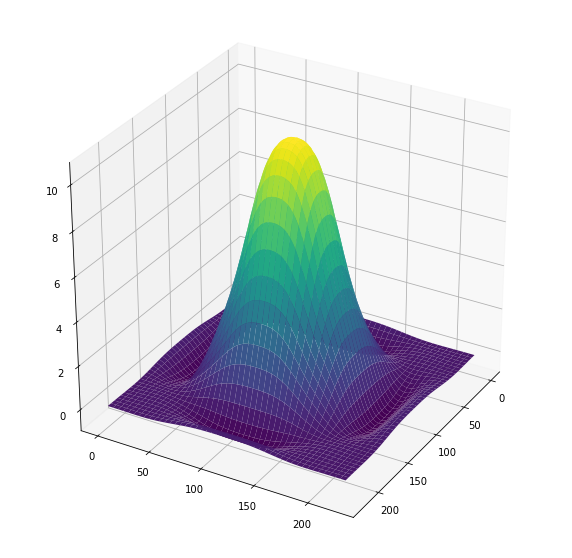

In [21]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

x,y = np.meshgrid(range(226), range(226))

ax.plot_surface(x, y, np.real(fake_cwt[0])[:,:,0], cmap='viridis', edgecolor='none')

ax.view_init(elev=30, azim=30)


In [22]:
fp, fp_x, fp_y = peak2d(np.real(fake_cwt[0])[:,:,0])

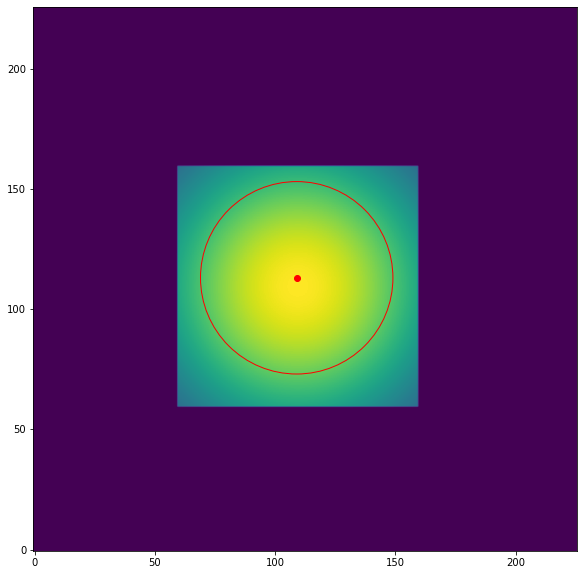

In [23]:
fig, ax = plt.subplots(figsize=(10,10))

test[test < 10] = 0
test[test > 3000] = 3000
plt.imshow(fake_img, origin='lower')

plt.plot(fp_x, fp_y, 'o', color='r')

draw_circle = plt.Circle((fp_x, fp_y), 40, fill=None, color='r')
ax.add_artist(draw_circle)

#ax.set_xlim(80,170)
#ax.set_ylim(100,180)

## TO DO:
 - Create fake data to test this!
 - Can also get an idea of the uncertaintly

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

x,y = np.meshgrid(range(256), range(256))

ax.plot_surface(x, y, np.real(cwt[0])[:,:,0], cmap='viridis', edgecolor='none')

ax.view_init(elev=30, azim=30)

#ax.scatter3D(peak_y, peak_x, peak, color='r')


In [ ]:
cwt2 = cwt_2d(test, [30], 'gaus')

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

x,y = np.meshgrid(range(256), range(256))

ax.plot_surface(x, y, np.real(cwt2[0])[:,:,0], cmap='viridis', edgecolor='none')

ax.view_init(elev=30, azim=30)

In [ ]:
a= np.real(cwt[0])[:,:,0]
np.unravel_index(a.argmax(), a.shape)

In [15]:
def peak2d(array):
    '''This function finds the peak in a 2D array by the
       recursive method.

       Complexity: O(n log m)'''

    n = len(array)
    m = len(array[0])

    j = m//2

    row = [i[j] for i in array]

    i = row.index(max(row))

    #print(i, j)

    if j > 0 and array[i][j] < array[i][j-1]:
        return peak2d([row[:j] for row in array]), i, j

    elif j < m - 1 and array[i][j] < array[i][j+1]:
        return peak2d([row[j:] for row in array]), i, j

    else:
        return array[i][j], i, j